http://www0.cs.ucl.ac.uk/staff/d.silver/web/Teaching_files/MDP.pdf

# MDPs

- In this notebook we focus on some basics: we'll first play with transition functions, reward functions, and total discounted rewards.

- Focusing on a simple MRP we'll find its state-value function and Bellman equations. Then we'll move to MDPs and again play with value function, policy and more Bellman equations.

# Relevant imports

In [6]:
using StatsBase
using Images, ImageMagick

# Defining our world:
- Figure source: (http://www0.cs.ucl.ac.uk/staff/d.silver/web/Teaching_files/MDP.pdf)
- Nodes represent states, edges represent transition probabilities

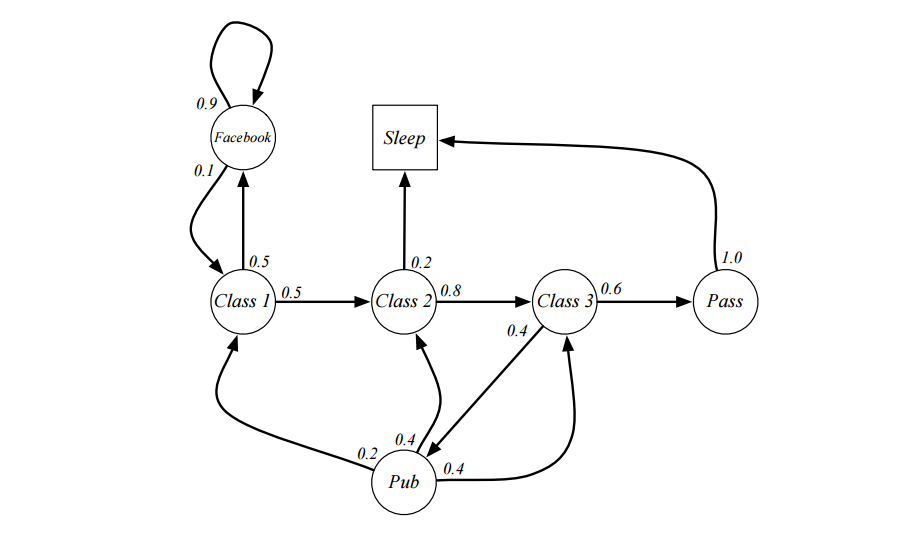

In [7]:
img = load("/home/marcin/Desktop/PPPP/student.png")

In [8]:
# We express the transition probabilities as an Array, where 
# P[i, j] is probability of moving from i -> j

P = [
    0.0  0.5  0.0  0.0  0.0  0.5  0.0;
    
    0.0  0.0  0.8  0.0  0.0  0.0  0.2;
    
    0.0  0.0  0.0  0.6  0.4  0.0  0.0;
    
    0.0  0.0  0.0  0.0  0.0  0.0  1.0;
    
    0.2  0.4  0.4  0.0  0.0  0.0  0.0;
    
    0.1  0.0  0.0  0.0  0.0  0.9  0.0;
    
    0.0  0.0  0.0  0.0  0.0  0.0  1.0];

# States are numbered as follows:
world = Dict(
    1 => "Class 1",
    2 => "Class 2",
    3 => "Class 3",
    4 => "Pass",
    5 => "Pub", 
    6 => "Facebook",
    7 => "Sleep"
);

# Sampling episodes of experience
### (According to transition matrix P)

In [9]:
function get_episode(P)
    state = 1
    episode = []
    
    while state != 7 # While we're not asleep
        push!(episode, state) 
        state = sample_next_state(state, P) 
    end
    
    return episode
end


function sample_next_state(state, P)
    probabilities = P[state,:][:] # the second [:] is used as numpy's .ravel()

    pvec = WeightVec(probabilities, 1) # for some reason "sample()" doesn't work with ordinary arrays, lol.
    state = sample(pvec)
    
    return state
end;

In [10]:
episodes = [get_episode(P) for i=1:5]

for ep in episodes
    states = [world[idx] for idx in ep]
    readable_episode = join(states, " => ") * "\n\n"
    print(readable_episode)
end

Class 1 => Class 2 => Class 3 => Pass

Class 1 => Facebook => Facebook => Facebook => Facebook => Facebook => Facebook => Facebook => Facebook => Facebook => Facebook => Facebook => Facebook => Facebook => Facebook => Facebook => Facebook => Facebook => Facebook => Facebook => Facebook => Facebook => Facebook => Class 1 => Class 2 => Class 3 => Pub => Class 2 => Class 3 => Pub => Class 3 => Pass

Class 1 => Facebook => Class 1 => Class 2

Class 1 => Facebook => Facebook => Facebook => Facebook => Facebook => Class 1 => Class 2 => Class 3 => Pass

Class 1 => Class 2 => Class 3 => Pub => Class 2 => Class 3 => Pass



# Defining Markov Reward Process

Recall that **Markov Reward Process** is defined as tuple: $<\mathcal{S}, \mathcal{P}, \mathcal{R}, \gamma>$

$\mathcal{R}_s = \mathbb{E}[R_{t+1}\ |\ S_t = s]$

$\gamma \in [0,1]$

In our case we have $R$ given as:

In [11]:
R = [-2., -2., -2., 10., 1., -1., 0.];

# Value Function

Recall that value function for a given state is defined as:
$v(s) = \mathbb{E}[G_t\ |\ S_t = s]$

where

$G_t = R_{t+1} + \gamma R_{t+2} + ... = \sum_{k=0}^{\infty}\gamma^k R_{t+k+1}$

As mentioned in the lecture, we can naively approximate $v(s)$ by simply running many, many episodes 
for each of the states in our Markov chain.

In [82]:
# FunFact: this naive implementation is around 100x faster than its Python counterpart
function get_episode(P; start_state=1)    
    state = start_state
    
    visited_states = Int16[]
    revieved_rewards = Float64[]
    
    while state != 7 # While we're not asleep
        reward = R[state]
        
        push!(visited_states, state)
        push!(revieved_rewards, reward)
        
        state = sample_next_state(state, P) end
    
    return visited_states, revieved_rewards
end


function get_discounted_return(gamma, rewards)    
    discounted_rewards = zeros(rewards)
    for i = 0:size(rewards, 1)-1
        discounted_rewards[i+1] = gamma^i * rewards[i+1] end
    
    G = sum(discounted_rewards)
    return G        
end


function estimate_value_function(P, R; num_episodes=3000, gamma=0.)    
    num_states = size(P, 1)
    state_returns = zeros(num_states)

    for start_state = 1:num_states
        for i = 1:num_episodes
            states, rewards = get_episode(P, start_state=start_state)
            total_return = get_discounted_return(gamma, rewards)
            
            state_returns[start_state] += total_return end
        state_returns[start_state] /= num_episodes end
    return state_returns
end;

# Approximating the value function for different values of $\gamma$

In [83]:
gamma = 0.
v_s = estimate_value_function(P, R, num_episodes=100, gamma=gamma) # Even num_episodes=1 and episode_len=1 would suffice

for (i, v) in enumerate(v_s)
    print(world[i] * "  =>  " * string(v) * "\n") end

Class 1  =>  -2.0
Class 2  =>  -2.0
Class 3  =>  -2.0
Pass  =>  10.0
Pub  =>  1.0
Facebook  =>  -1.0
Sleep  =>  0.0


In [87]:
gamma = 0.9
v_s = estimate_value_function(P, R, num_episodes=10000, gamma=gamma) # Even num_episodes=1 and episode_len=1 would suffice

for (i, v) in enumerate(v_s)
    print(world[i] * "  =>  " * string(round(v, 1)) * "\n") end

Class 1  =>  -5.0
Class 2  =>  0.9
Class 3  =>  4.1
Pass  =>  10.0
Pub  =>  2.0
Facebook  =>  -7.6
Sleep  =>  0.0


### We see, that indeed $\mathbb{E}[v(s)]$ converges to the values from the slide

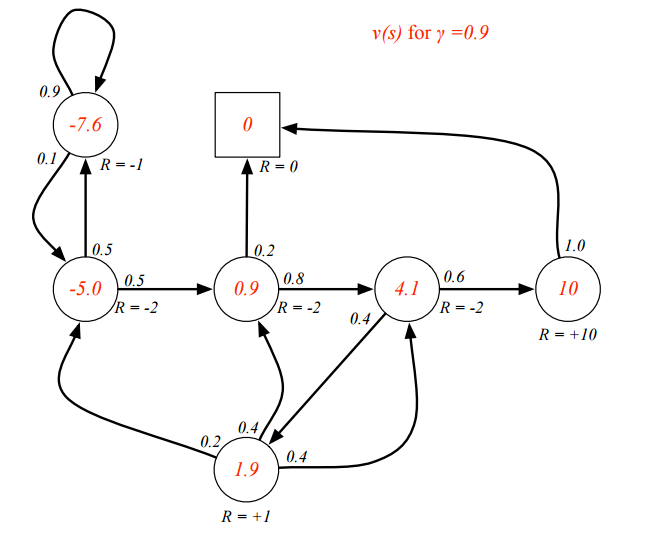

In [8]:
load("/home/marcin/Desktop/PPPP/student2.png", )

# Bellman equations

We now turn toward Bellman equations. 

Recall, that value function can be decomposed into two parts as follows:

$v(s) = \mathbb{E}[R_{t+1} + \gamma v(S_{t+1})\ |\ S_t=s] $

which is equivalent to

$v(s) = \mathcal{R_s} + \gamma\ \sum \limits_{s' \in S} P_{ss'}v(s') $

where $P{ss'}$ is, of course, probability of transitioning from s to s'

This makes intuitive sense: given we're in the state $S_t$, we want to know how much reward we can expect in the future. This is given as value at each state $s'$ weighted by a probability of actually getting to that state. We can have a really good state $s'$ with $v(s') = 100$, but we'll never get that reward if $P_{ss'} = 0$. 

In matrix form we have:

$
\begin{bmatrix}
    v(1) \\
    \vdots \\
    v(n)
\end{bmatrix} 
= 
\begin{bmatrix}
    \mathcal{R}_1 \\
    \vdots \\
    \mathcal{R}_n \\
\end{bmatrix}
+ 
\gamma
\begin{bmatrix}
    \mathcal{P}_{11} & \cdots & \mathcal{P}_{1n} \\
    \vdots &  & \vdots \\
    \mathcal{P}_{n1} & \cdots & \mathcal{P}_{nn} \\
\end{bmatrix}$

which makes sense, since it means that $v(1) = \mathcal{R}_1 + \gamma \cdot [\mathcal{P}_{11}\cdot v(1) + \mathcal{P}_{12} \cdot v(2) + \cdots + \mathcal{P}_{1n} \cdot v(n)]$

And since this is a linear equation, we should be able to find an analytcal solution.

if $v = \mathcal{R} + \gamma \cdot \mathcal{P}v$

then $(\mathbb{1} - \gamma\cdot\mathcal{P})v = \mathcal{R}$

hence $v = (\mathbb{1} - \gamma\cdot\mathcal{P})^{-1} \cdot \mathcal{R}$

Note that $\mathbb{1}$ stands for identity matrix.

The problem here is finding the inverse matrix $(\mathbb{1} - \gamma\cdot\mathcal{P})^{-1}$, which is hard in general. For student MRP we can do it easily, but this method will fail for larger problems.

In [88]:
v = (eye(7) - γ * P)^-1 * R
round(v, 1)

7-element Array{Float64,1}:
 -5.0
  0.9
  4.1
 10.0
  1.9
 -7.6
  0.0

# MDPs

We now finally turn towards MDPs, i.e. Markov Decicion Processes

Recall that **MDP** is simply a Markov Rewards Process with decisions. 

We define it as a tuple $<\mathcal{S}, \mathcal{A}, \mathcal{P}, \mathcal{R}, \mathcal{\gamma}>$, where the newly introduced $\mathcal{A}$ is a finite set of actions. 

In this setting we have to update our definition of $\mathcal{P}$ since the transition probabilities will now depend on the action we choose. We also modify the expression for $\mathcal{R}$

$\mathcal{P}_{ss'}^a = \mathbb{P}[S_{t+1} = s'\ |\ S_t = s, A_t = a]$ 

$\mathcal{R}_s^a = \mathbb{E}[R_{t+1}\ |\ S_t = s, A_t = a]$

This is closely related to the notion of **policy**: if our agent have a set of actions $\mathcal{A}$ to choose from, then policy **$\pi$** defines its behaviour. Formally we write:

**$\pi(a\ |\ s) = \mathbb{P}[A_t = a\ |\ S_t = s]$**

which means that our policy does not have to be deterministic.

This brings us to a new quantity, namely action-value function which defines the expected return
starting from state $s$, taking action $a$, and then following policy $\pi$. This is an extremely important notion for all of RL:

$q(s,\ a) = \mathbb{E}[G_t\ |\ S_t=s, A_t=a]$

Now, when navigating through the student MDP, we have to do two things at each timestep: sample action $a$, and sample the next state $s'$ according to probability $P_{ss'}^{\ a}$

First, let's us redifne the rewards: these are no longer associated with a specific state, but rather with a $<state, action>$ tuple:

In [105]:
world

Dict{Int64,ASCIIString} with 7 entries:
  7 => "Sleep"
  4 => "Pass"
  2 => "Class 2"
  3 => "Class 3"
  5 => "Pub"
  6 => "Facebook"
  1 => "Class 1"

In [ ]:
R = zeros(P)

R[1, 6] = -1 # <Class 1, Study, Facebook>
R[1, 2] = -2 # <Class 1, Facebook, Facebook>
R[2, ]



In [ ]:
function get_episode(P; initial_state=1)
    s = initial_state
    episode = Array{ Tuple{Int16, Int16, Float64} }{1} 
    
    while s != 7 # While we're not asleep
        push!(episode, (s, a, r)) 
        
        a = sample_action(s)
        s_prime = sample_state(s, a)   
        r = reward(s, a, s_prime)
        s = s_prime
        
    return episode

In [ ]:
# FunFact: this naive implementation is around 100x faster than its Python counterpart

function get_v(P, R; num_episodes=3000, episode_len=100, γ=0.)
    
    returns = zeros(R)
    num_states = size(P)[1]   

    for start_state = 1:num_states # We want to compute v for every state
        μ = 0. # \mu will be our empirical mean
        for i = 1:num_episodes
            state = start_state
            G = 0. 
            for j = 0:episode_len-1 # We only allow this many episodes
                G += γ^j * R[state]
                pvec = WeightVec( P[state, :][:], 1)
                state = sample(pvec)
                if state == 7
                    break
                end
            end # Yeah, I miss Python's lack of "ends" as well...
            μ += G
        end
        μ /= num_episodes
        returns[start_state] = μ
    end
    returns
end;